<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC%D1%8B_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание Ultra pro**

Сделайте классификацию цифр mnist, используя только Xtrain (без Ytrain). 

Предобучите автокодировщик. Возьмите предобученный encoder.

Нужно кластеризовать скрытое пространство, полученное из encoder (т. е. кластеризовать изображения, так как при подаче изображения на вход encoder’у получится скрытое пространство).

In [1]:
#загрузка библиотек
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, MaxPooling2D, Input, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
#загружаем данные из базы
(xTrain, yTrain), (xTest, yTest) = mnist.load_data()
#нормализуем данные
xTrain = xTrain.astype('float32') / 255
xTest = xTest.astype('float32') / 255

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
#меняем форму
xTrain = xTrain.reshape(-1, 28, 28, 1)
xTest = xTest.reshape(-1, 28, 28, 1)
#посмотрим размерность
print(xTrain.shape)
print(xTest.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
# функция создания базового автокодировщика
def baseAutoencoder(shape=(28,28,1), latent_dim=10):
    models = {}

    #Encoder
    img_input = Input(shape=(28, 28, 1))
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Flatten()(x)

    l = Dense(latent_dim, activation='relu')(x)

    #Decoder

    z = Dense(64*7*7, activation='relu')(l)
    x = Reshape((7, 7, 64))(z)

    x = Conv2DTranspose(64, (2, 2), padding='same', activation='relu', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, (2, 2), padding='same', activation='relu', strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    output = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    # модель энкодера
    models['encoder'] = Model(img_input, l)
    
    # модель вариационного автокодировщика
    models["ae"] = Model(img_input, output)

    return models

In [5]:
#функция для вывода изображений
def plotImages(xTrain, pred, shape=(28, 28)):
    #зададим количество картинок, сколько хотим показать
    n = 5
    plt.figure(figsize=(14, 7))
    for i in range(n):
        index = np.random.randint(0, pred.shape[0])
        # Показываем картинки из тестового набора
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(xTrain[index].reshape(shape))
        plt.gray()
        #скрываем выводы координатных осей
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Показываем восстановленные картинки
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pred[index].reshape(shape))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [6]:
# получим модели
models = baseAutoencoder()
encoder = models['encoder']
ae = models['ae']
# скомпилируем автокодировщик
ae.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
# обучим автокодировщик
ae.fit(xTrain[:50000], xTrain[:50000], batch_size=32, epochs=50, validation_data=(xTrain[50000:], xTrain[50000:]))

Epoch 1/50
1563/1563 [==============================] - 22s 8ms/step - loss: 0.0376 - val_loss: 0.0274
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0263 - val_loss: 0.0234
Epoch 3/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0229 - val_loss: 0.0218
Epoch 4/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0217 - val_loss: 0.0208
Epoch 5/50
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0208 - val_loss: 0.0207
Epoch 6/50
1563/1563 [==============================] - 13s 9ms/step - loss: 0.0202 - val_loss: 0.0196
Epoch 7/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 8/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0194 - val_loss: 0.0193
Epoch 9/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0191 - val_loss: 0.0195
Epoch 10/50
1563/1563 [==============================] - 13s 8ms/step - l

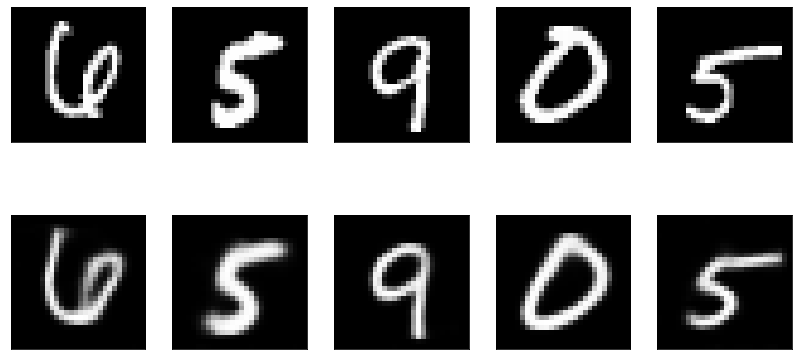

In [7]:
#выведем исходные и восстановленные картинки
predictMnistTest = (ae.predict(xTest) * 255).astype('uint8')
plotImages(xTest, predictMnistTest, shape=(28, 28))

In [8]:
# получим скрытое пространство
latent_pred = encoder.predict(xTrain)
latent_pred.shape

(60000, 10)

In [9]:
# кластеризация
# задаем количество кластеров
clustersCount = 100
# создаем объект kmeans
kmean = KMeans(clustersCount)
# производим кластеризацию данных
kmean.fit(latent_pred)
# получаем метки кластеров
labels = kmean.labels_

In [10]:
# отобразим метки кластеров
print(labels)

[53 87 97 ... 51 43 63]


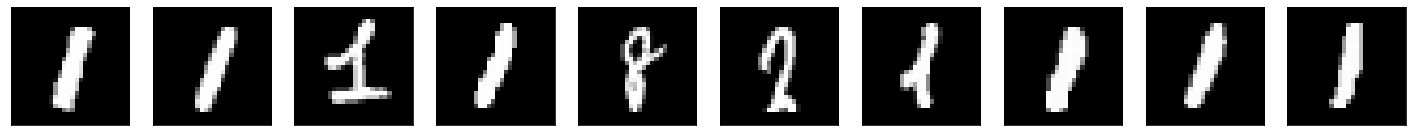

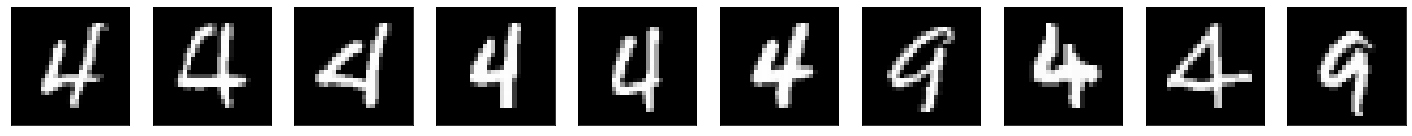

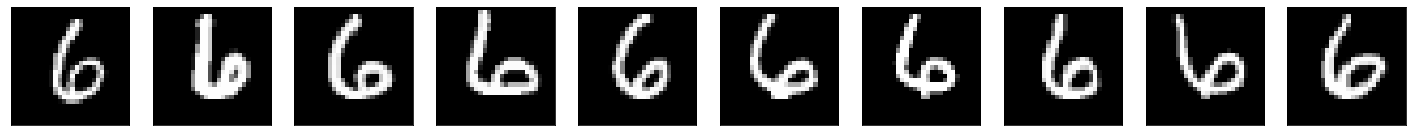

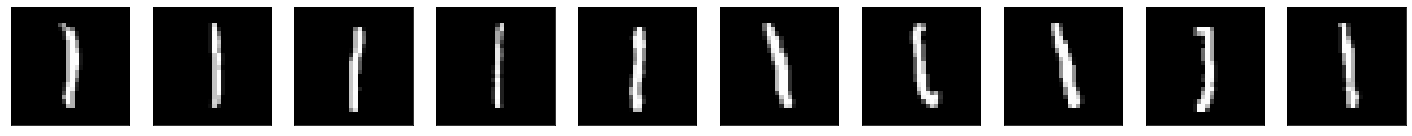

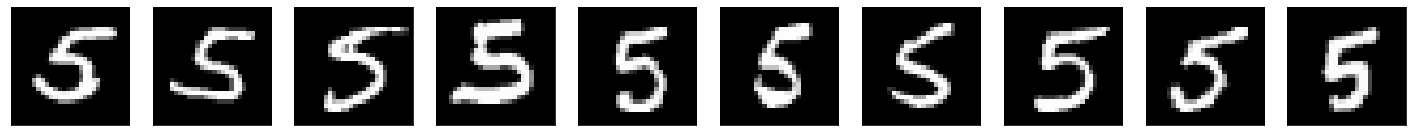

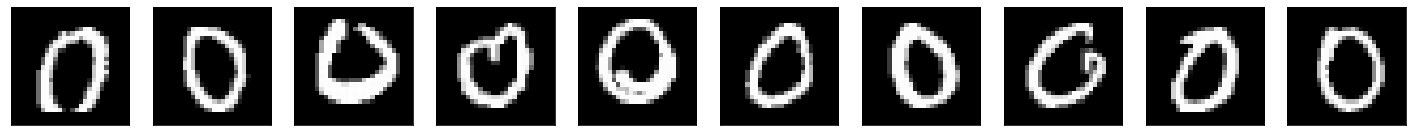

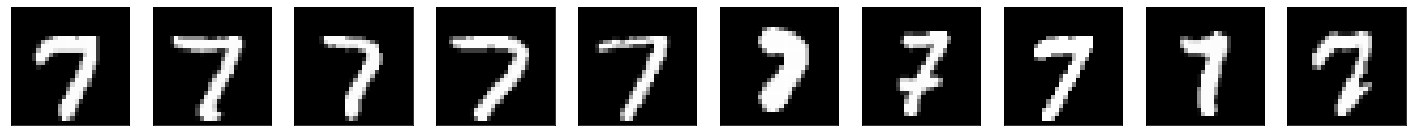

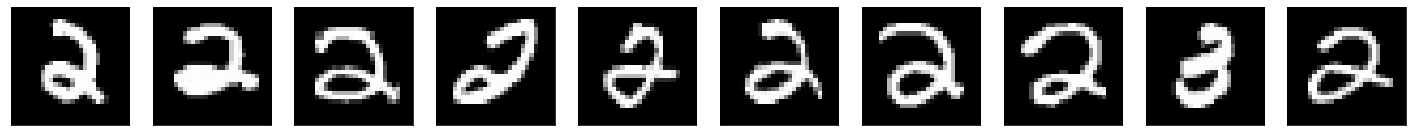

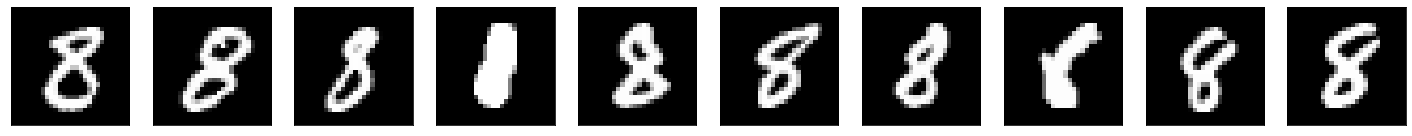

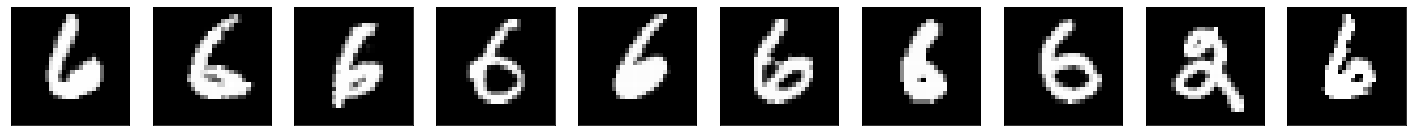

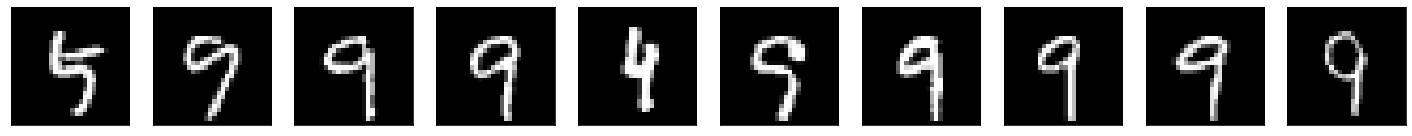

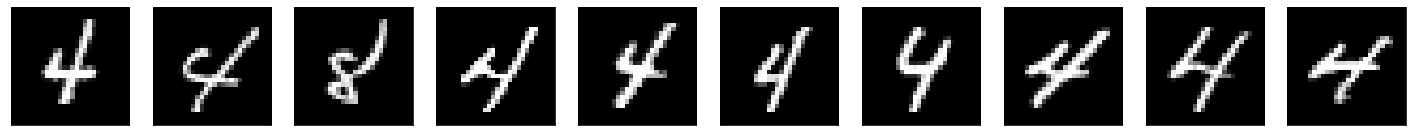

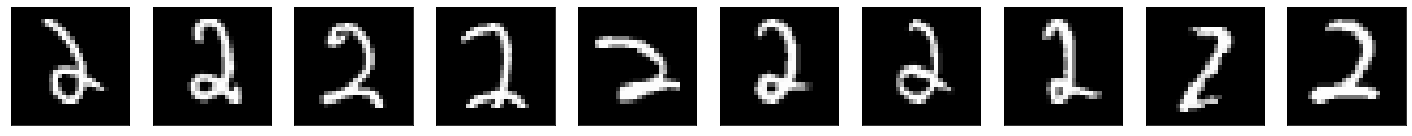

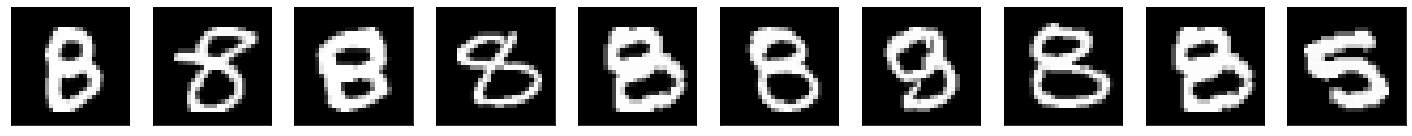

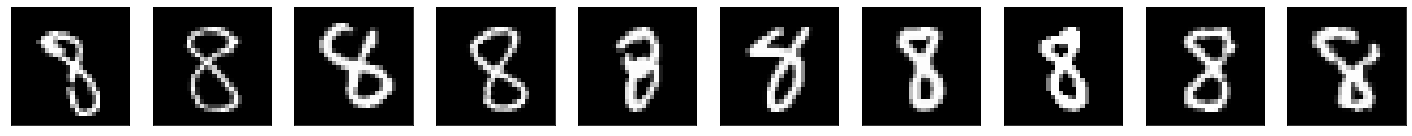

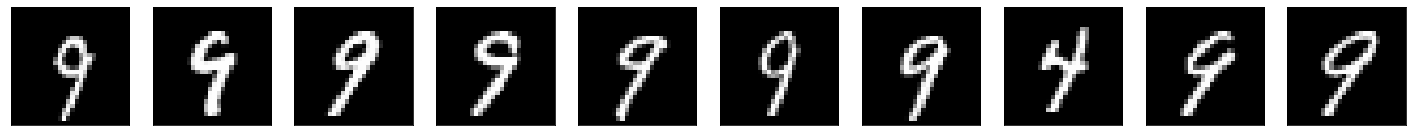

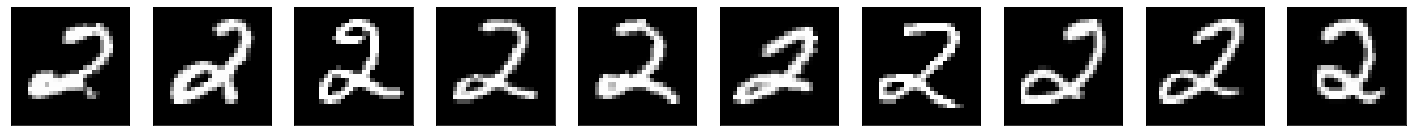

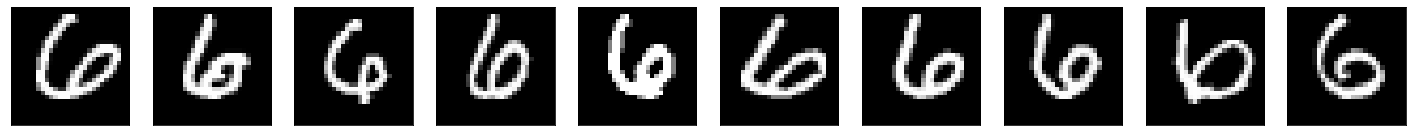

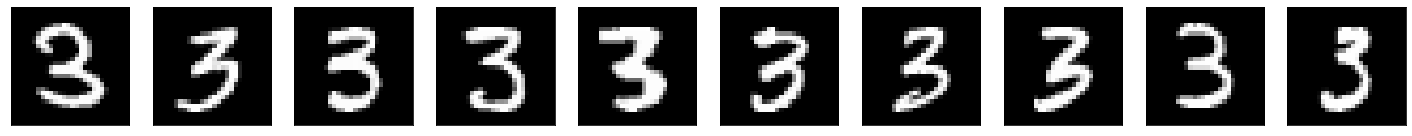

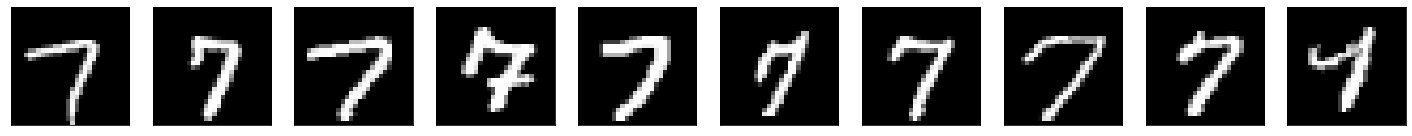

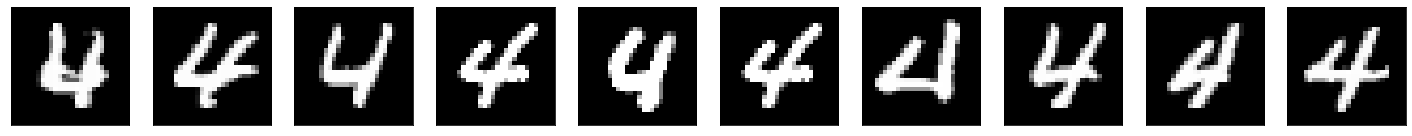

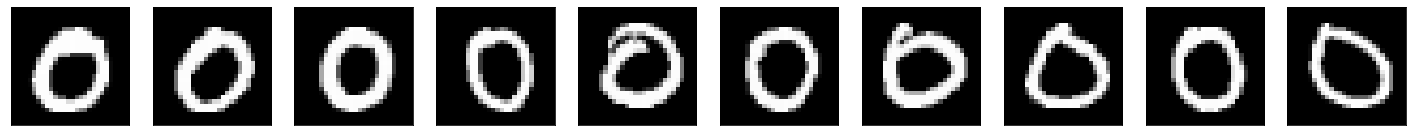

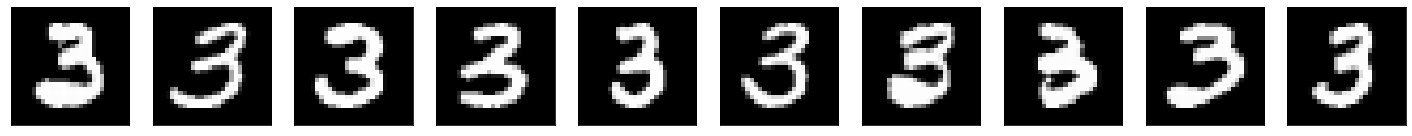

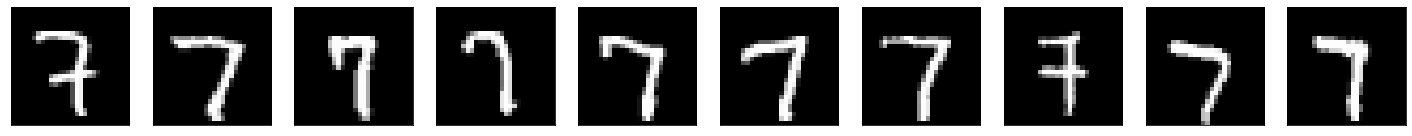

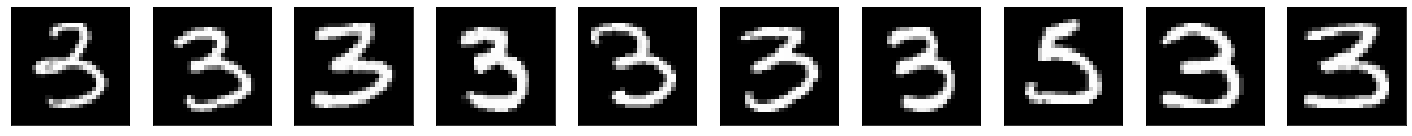

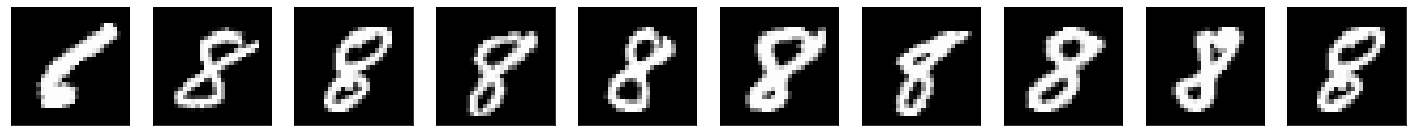

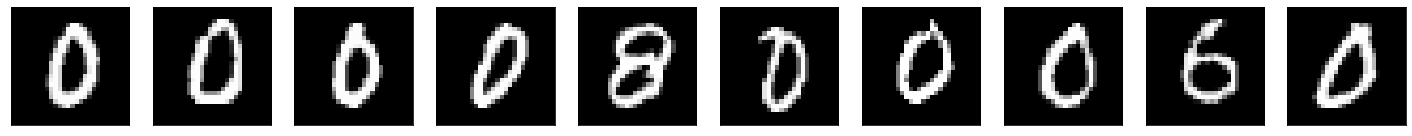

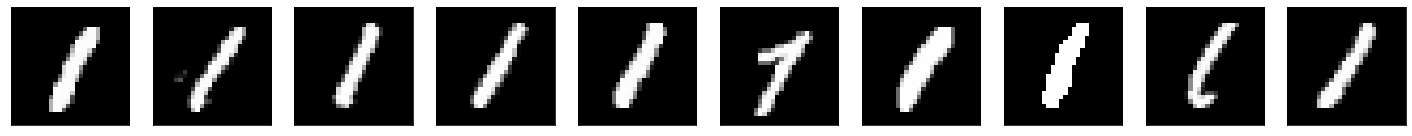

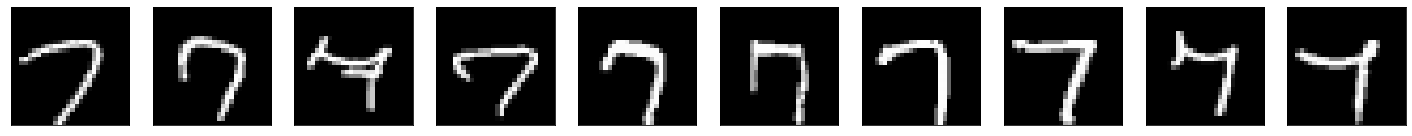

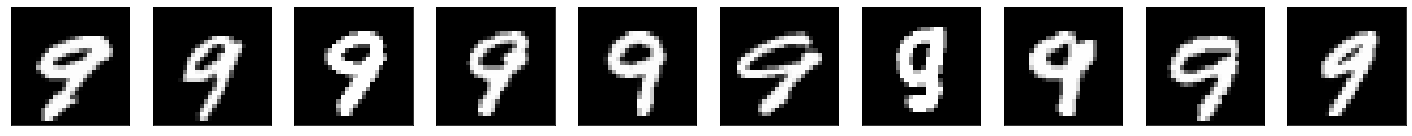

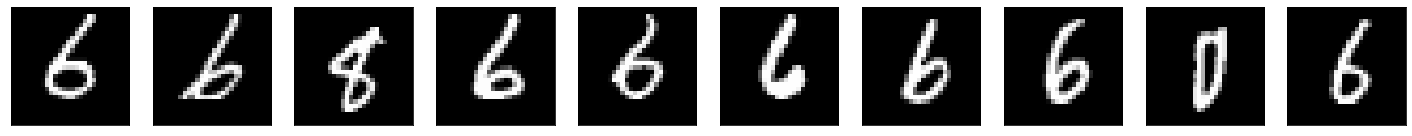

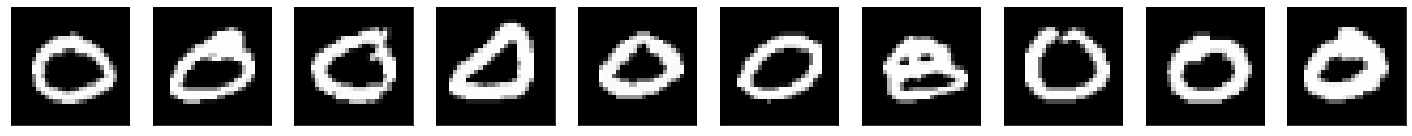

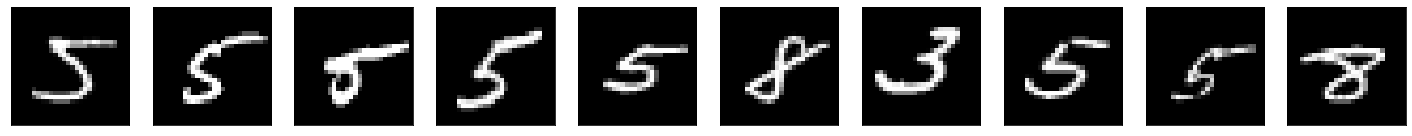

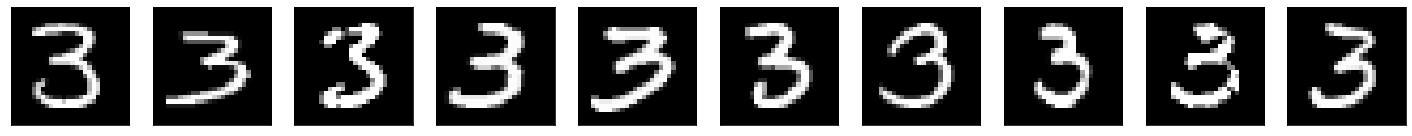

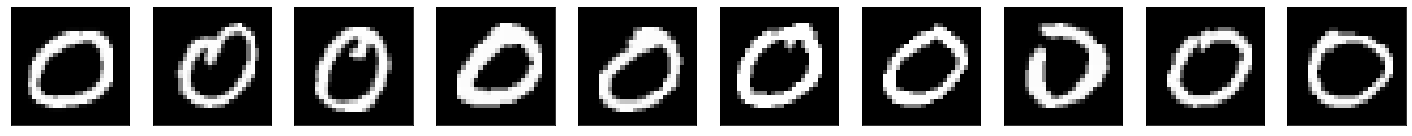

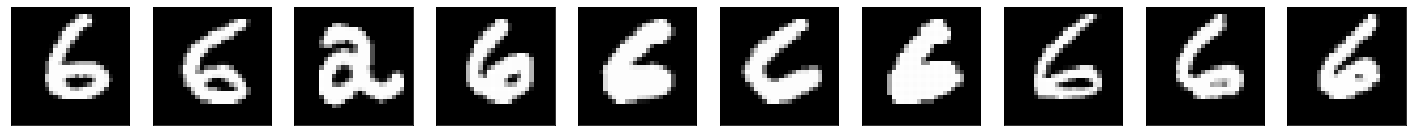

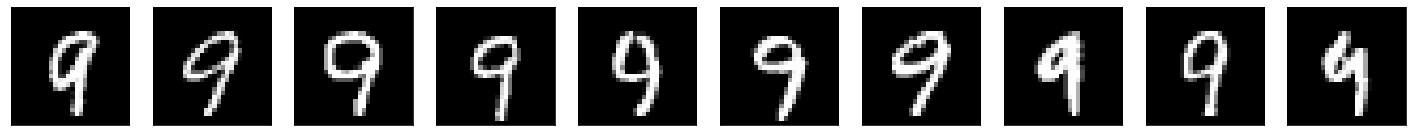

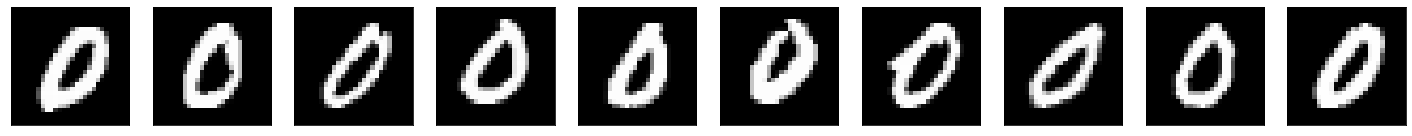

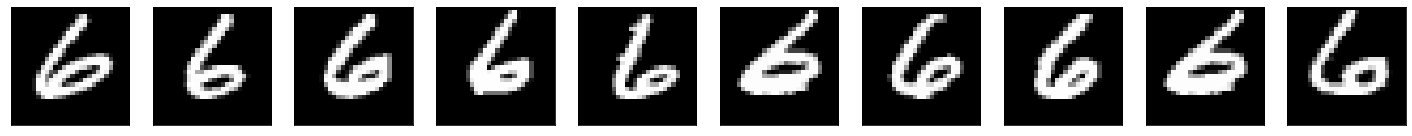

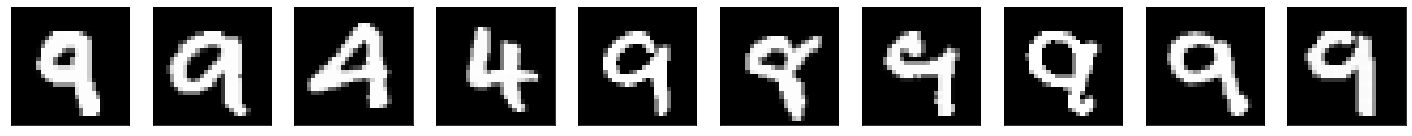

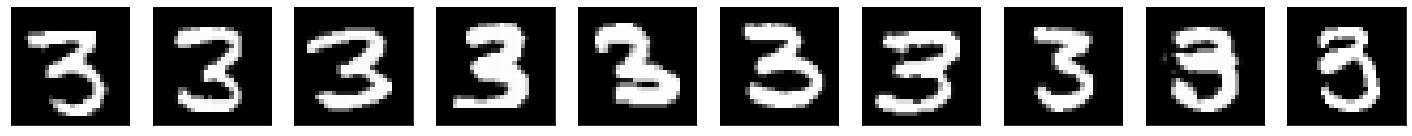

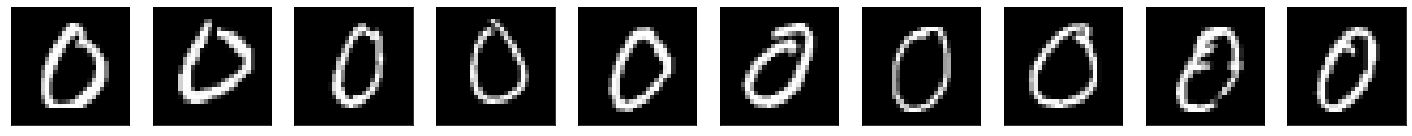

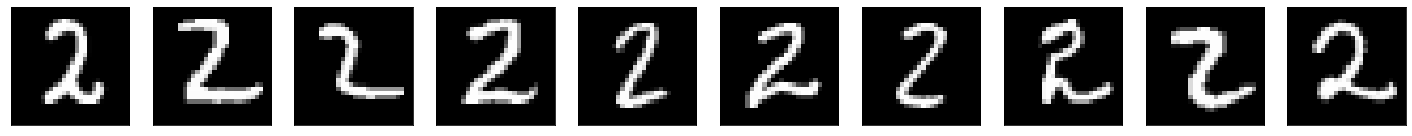

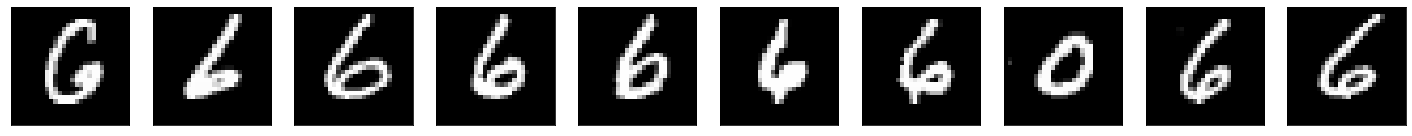

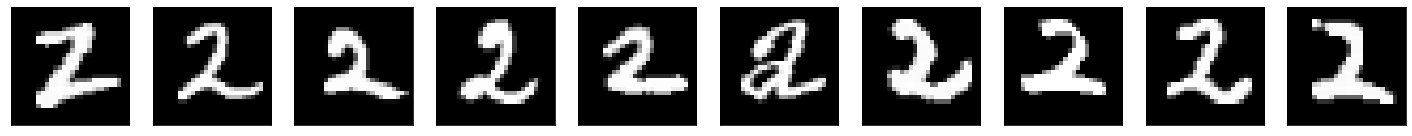

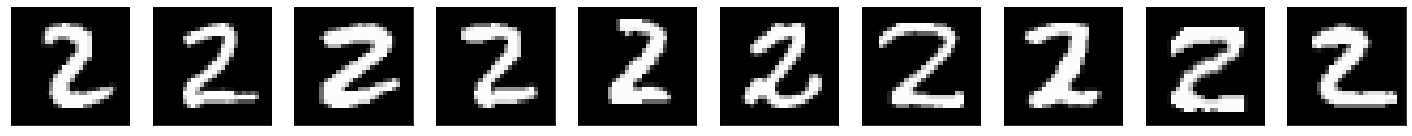

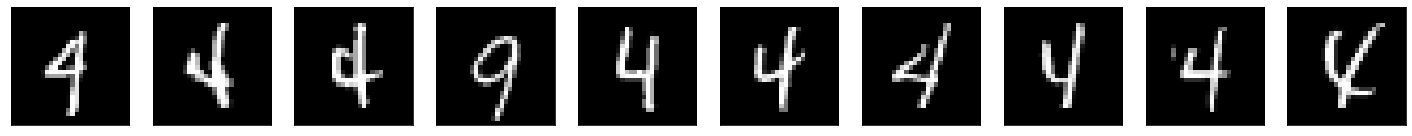

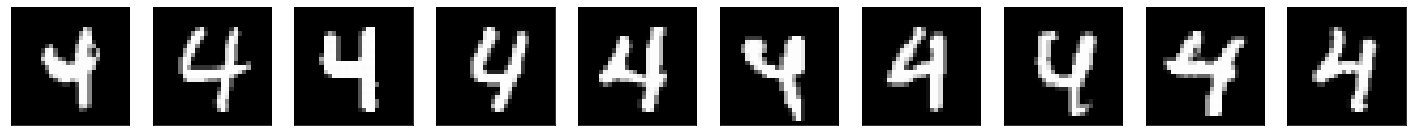

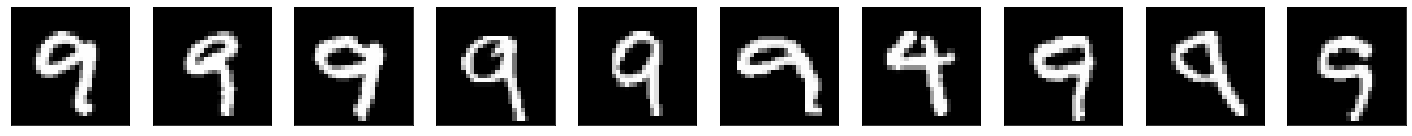

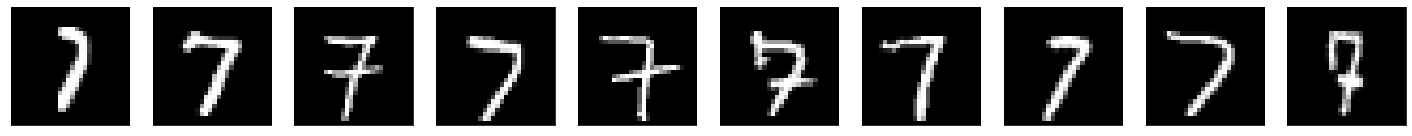

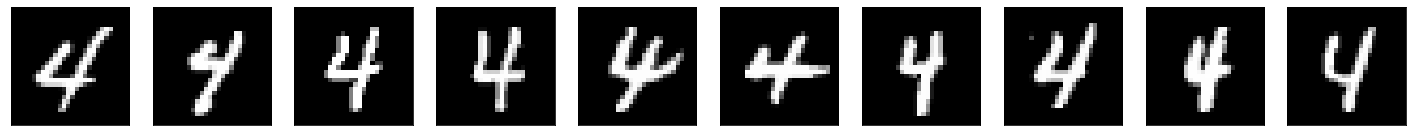

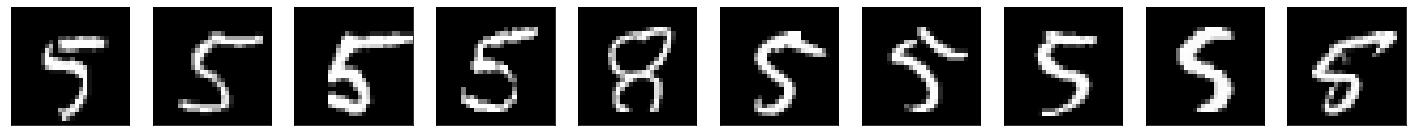

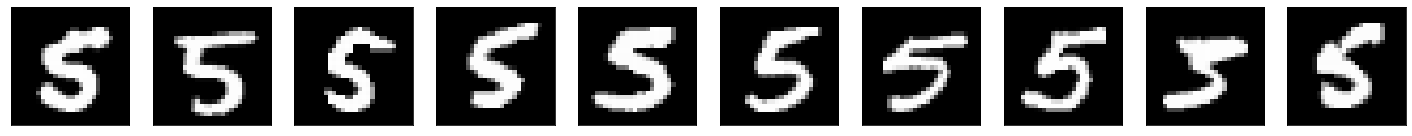

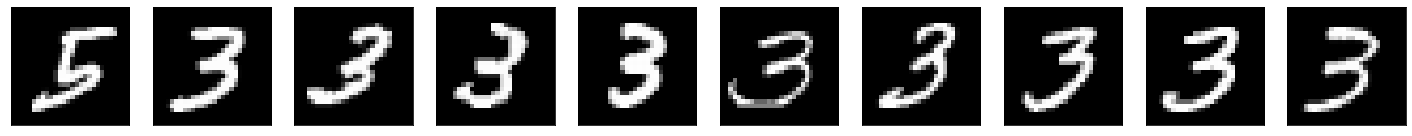

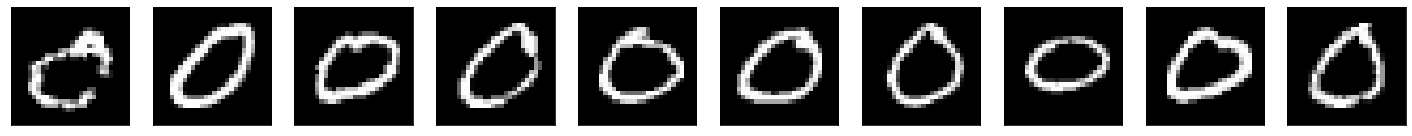

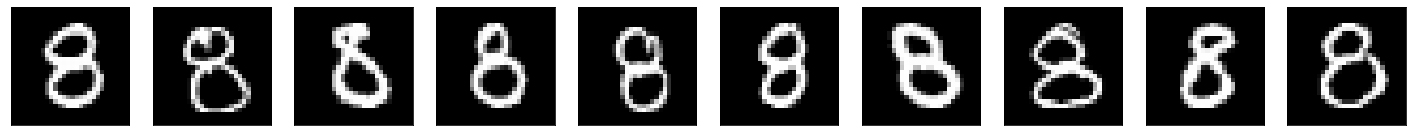

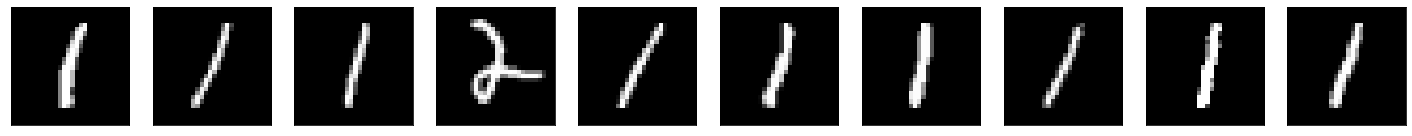

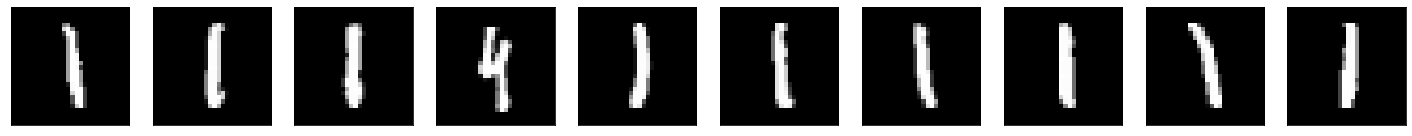

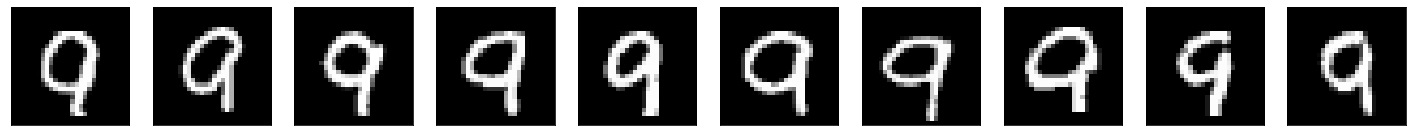

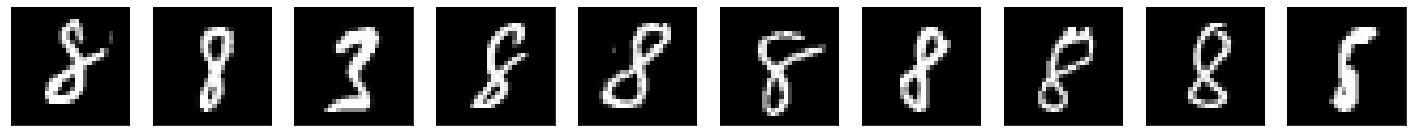

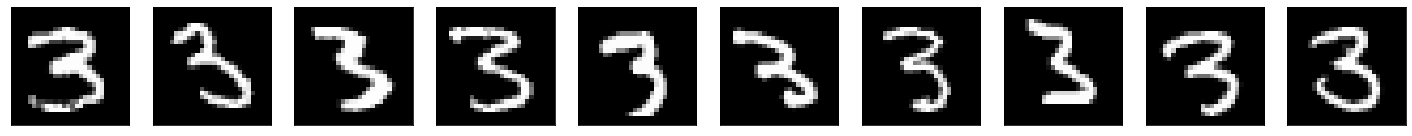

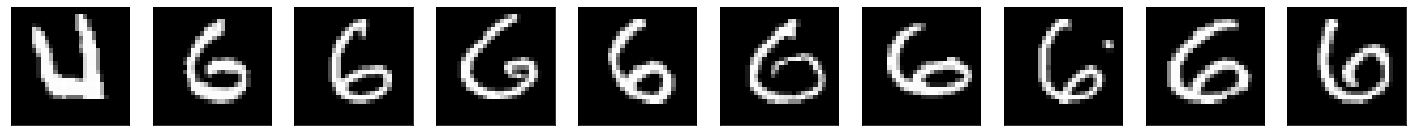

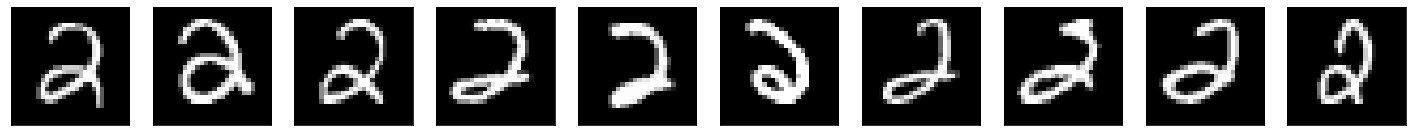

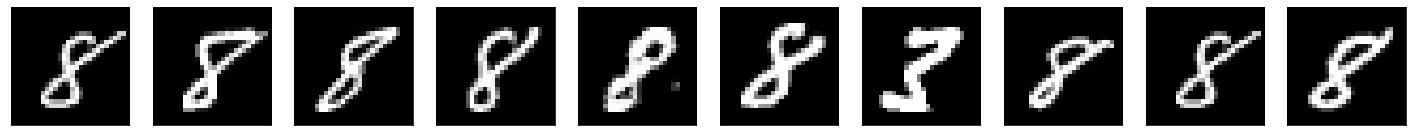

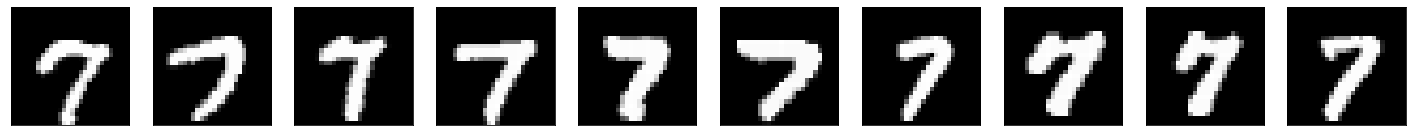

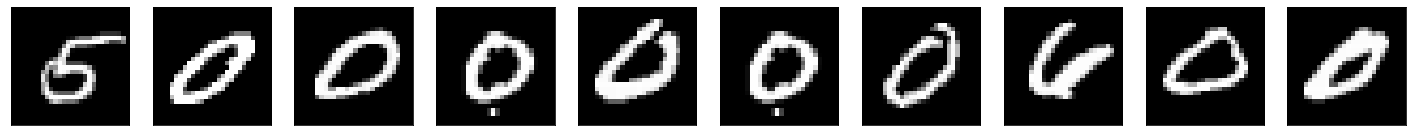

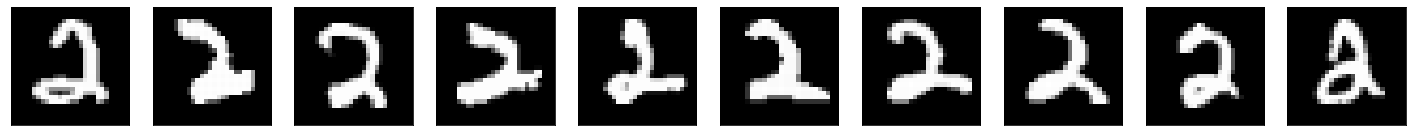

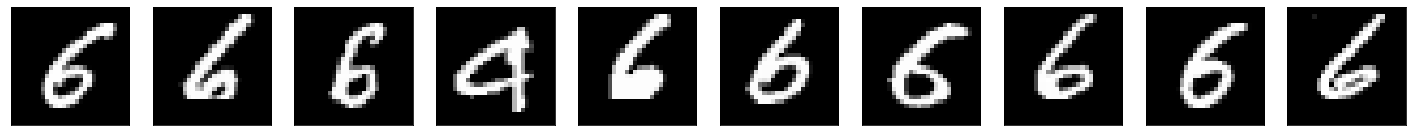

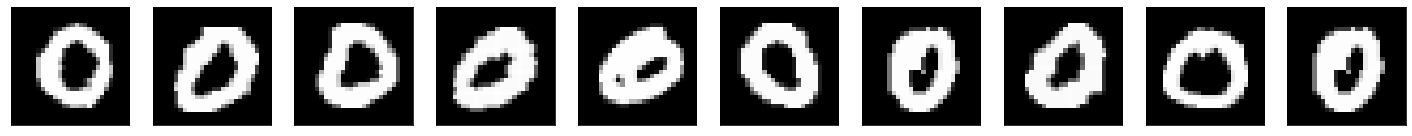

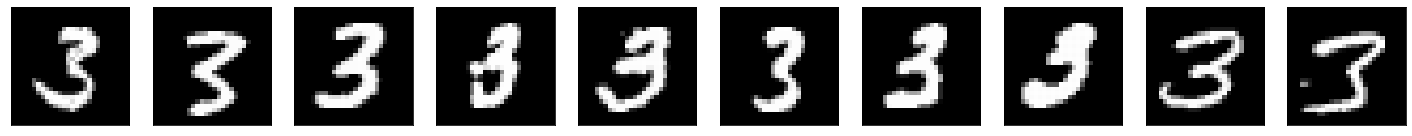

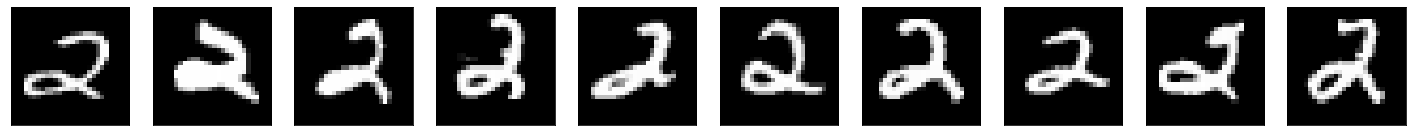

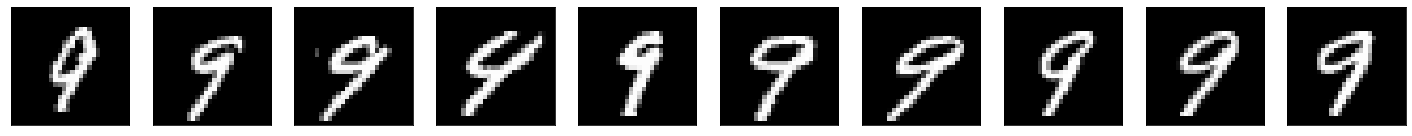

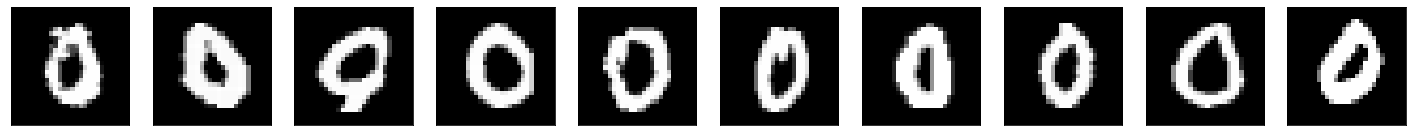

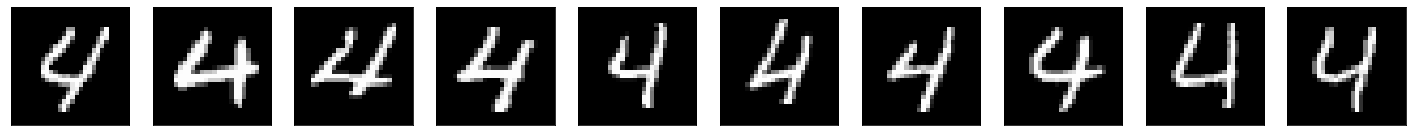

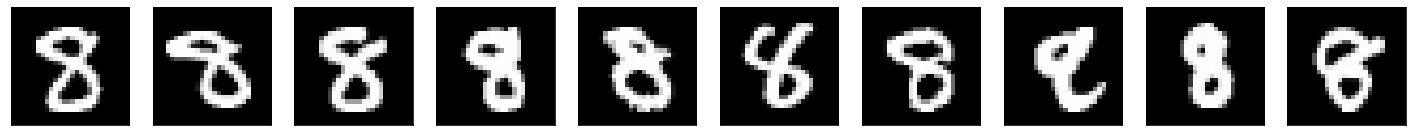

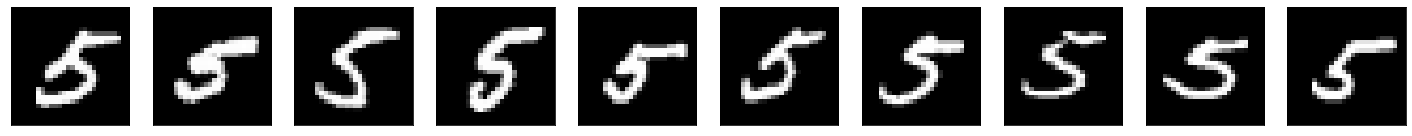

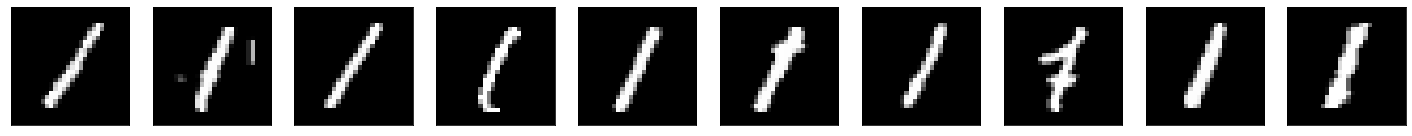

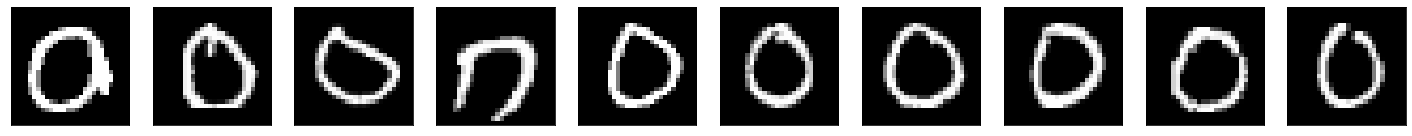

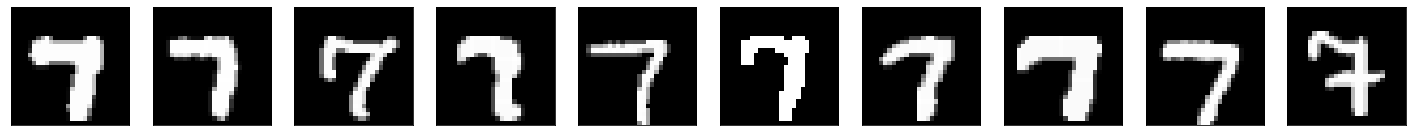

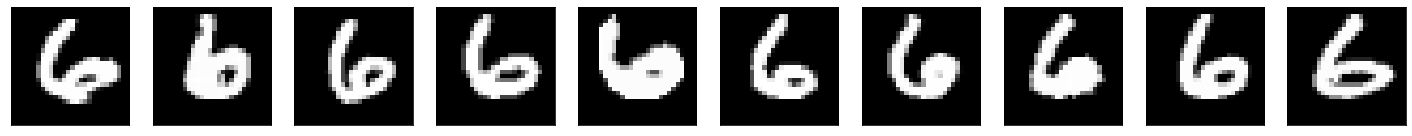

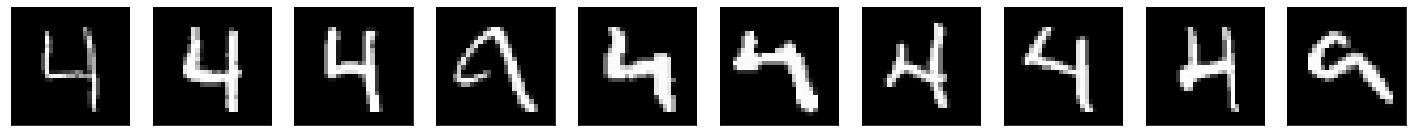

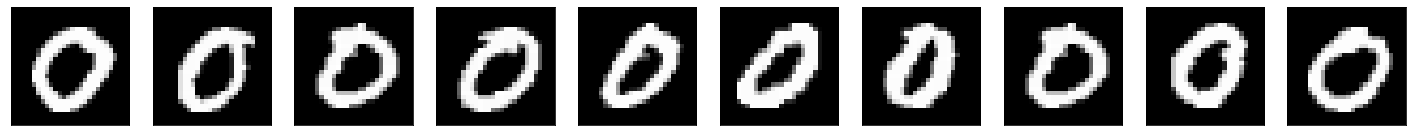

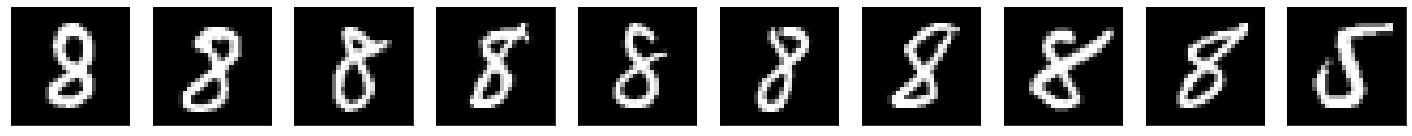

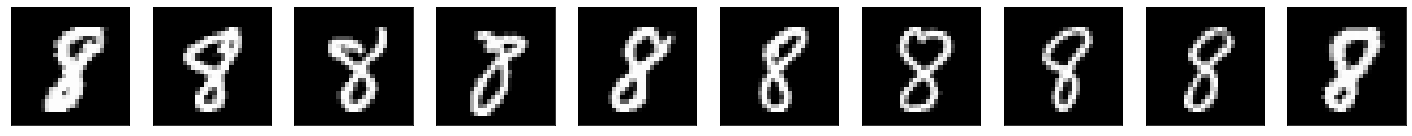

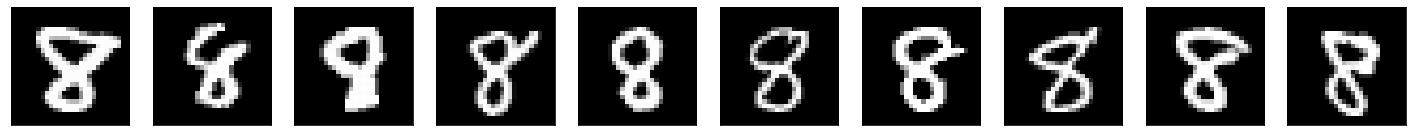

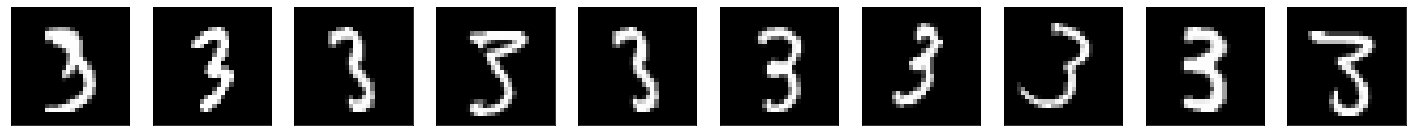

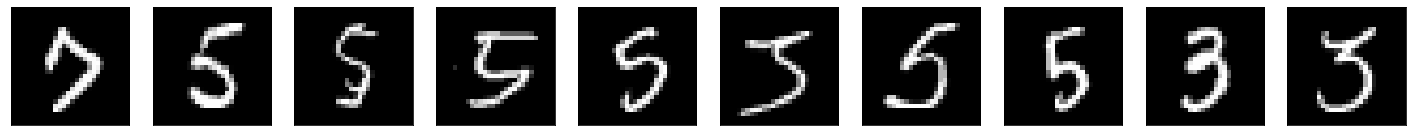

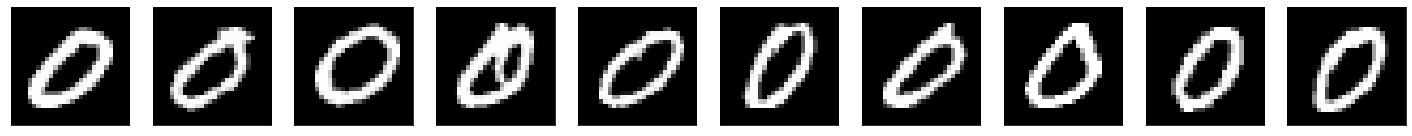

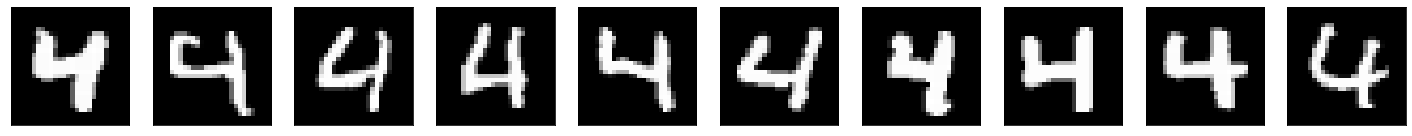

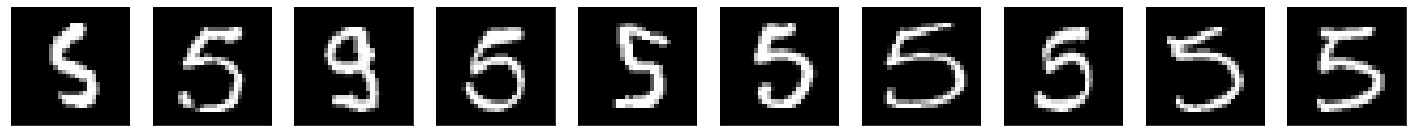

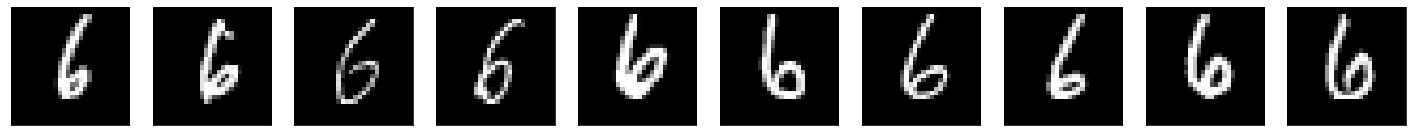

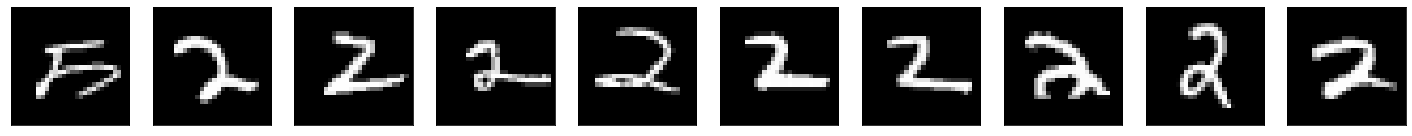

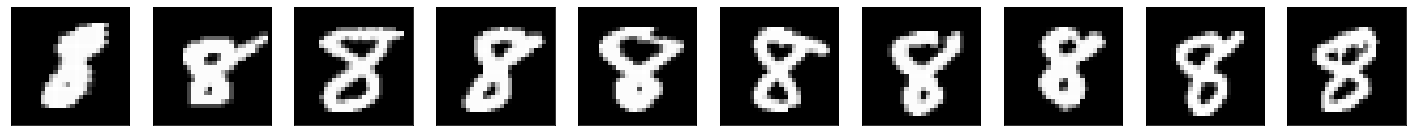

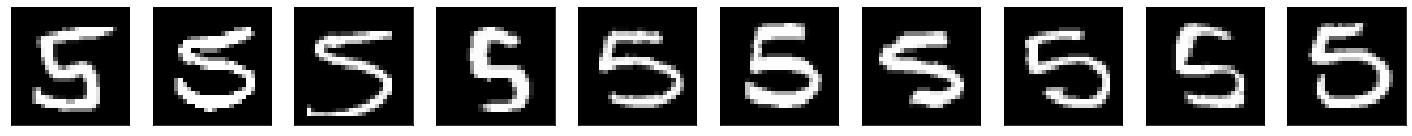

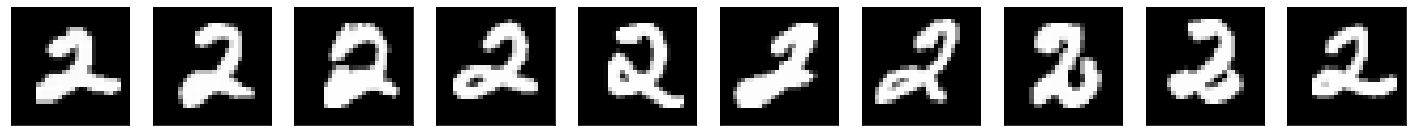

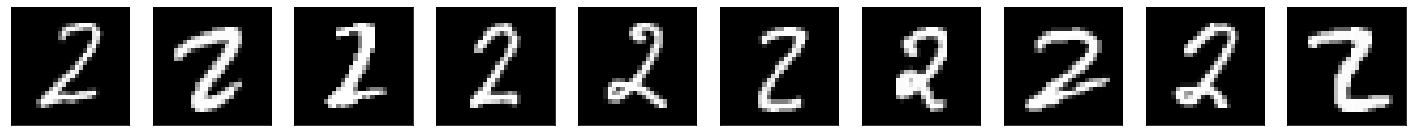

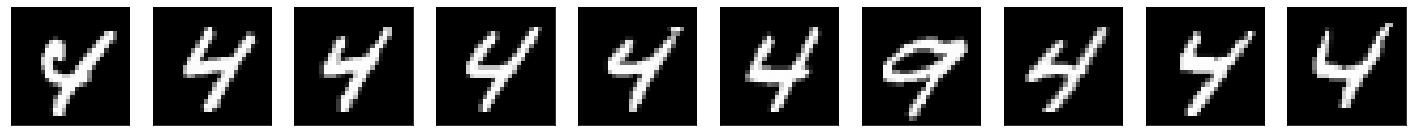

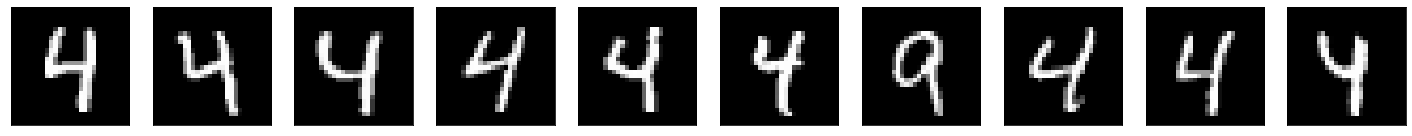

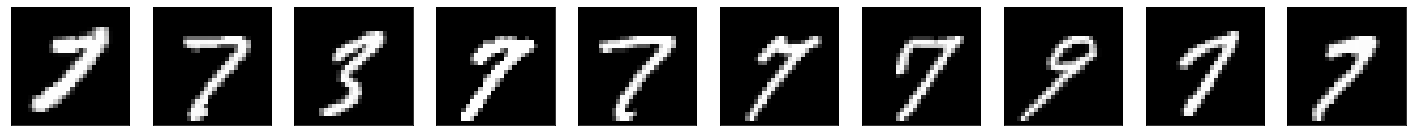

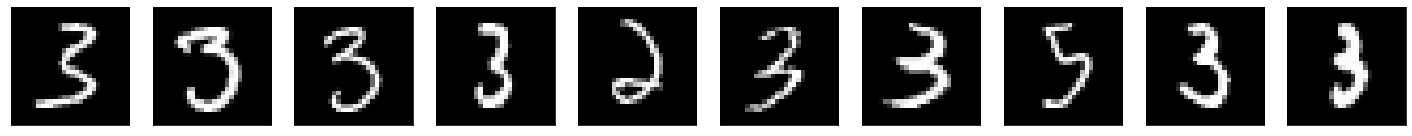

In [12]:
# выведем картинки каждого кластера
for i in range(100):
    # выделим кластер
    claster = xTrain[labels==i]
    plt.figure(figsize=(25, 5))
    for j in range(10):
        # случайный индекс
        index = np.random.randint(0, claster.shape[0])
        # Выведем область рисования
        ax = plt.subplot(1, 10, j + 1)
        # Отрисуем картинки
        plt.imshow(claster[index].reshape((28, 28)))
        # переведем в черно-белый цвет
        plt.gray()
        # скроем координатные оси
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Получилось очень красиво. Жирно нарисованные цифры отдельно, и почти все цифры в каждом кластере имеют свое значение - девятки с девятками, пятерки с пятерками и т.д.